# Assignment
Analyze and compare the performance of a standard ResNet model and a ResNet model with an attention module (CBAM) for image classification.
- Train both models on a given dataset.
- Compare results between the standard ResNet and the attention-enhanced ResNet.
- Discuss findings and provide conclusions on whether the attention mechanism improves classification performance.

In [1]:
# # Download the dataset
import gdown
import os

file_id = "1uxav6g0wBXfQ-dUGBC5ePQfBeDjFip2T"

gdown.download(f"https://drive.google.com/uc?id={file_id}", "cat_and_dog.zip", quiet=False)

os.system("unzip -q cat_and_dog.zip -d cat_and_dog_dataset")

print("Dataset downloaded and extracted")


Downloading...
From (original): https://drive.google.com/uc?id=1uxav6g0wBXfQ-dUGBC5ePQfBeDjFip2T
From (redirected): https://drive.google.com/uc?id=1uxav6g0wBXfQ-dUGBC5ePQfBeDjFip2T&confirm=t&uuid=4cb34162-0732-4efd-bfd4-9adac6d6adc8
To: /content/cat_and_dog.zip
100%|██████████| 67.6M/67.6M [00:00<00:00, 115MB/s]


Dataset downloaded and extracted


In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

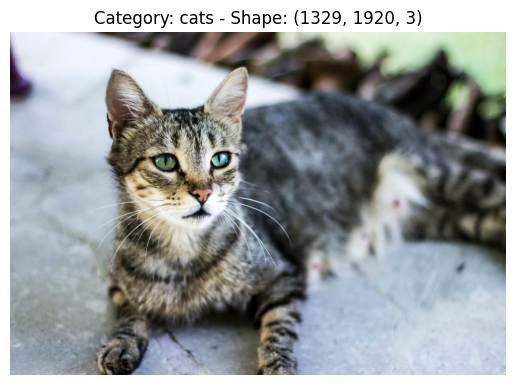

Image shape: (1329, 1920, 3)


In [3]:
# Visualize an input cat image
dataset_root = "cat_and_dog_dataset"
train_dir = os.path.join(dataset_root, "train")

category = 'cats'
image_dir = os.path.join(train_dir, category)

assert os.path.exists(image_dir), f"Error: Category directory '{image_dir}' does not exist!"
assert len(os.listdir(image_dir)) > 0, f"Error: No images found in '{image_dir}'!"

image_name = os.listdir(image_dir)[0]
image_path = os.path.join(image_dir, image_name)

image = Image.open(image_path).convert("RGB")
image_array = np.array(image)

plt.imshow(image)
plt.title(f"Category: {category} - Shape: {image_array.shape}")
plt.axis('off')
plt.show()

print(f"Image shape: {image_array.shape}")


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [5]:
# Prepare dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)), # Add resize
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
# Use only 1/10 of the data
train_indices = torch.randperm(len(trainset))[:len(trainset) // 10]
trainset = torch.utils.data.Subset(trainset, train_indices)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

In [6]:
class Network(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(Network, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0])

        self.layer2 = self._make_layer(block, 128, num_blocks[1])
        self.layer3 = self._make_layer(block, 256, num_blocks[2])
        self.layer4 = self._make_layer(block, 512, num_blocks[3])
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(self.in_channels, out_channels))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [7]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # Calculate each channels avg and max value in order to let network focus on overall info of different channel
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1), # C//r=1000/16=62
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)
        )
        # self.fc = nn.Sequential(
        #     nn.Linear(in_channels, in_channels // reduction_ratio),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(in_channels // reduction_ratio, in_channels)
        # )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x): # x=[B, C, H, W]
        avg_out = self.fc(self.avg_pool(x)) # [B, C, 1, 1]
        max_out = self.fc(self.max_pool(x)) # [B, C, 1, 1]
        out = avg_out + max_out
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True) # DIM is in the first dimension, which is after the batch size, so it is defined as [B,1,H,W].
        max_out, _ = torch.max(x, dim=1, keepdim=True) # [B, 1, H, W]
        x = torch.cat([avg_out, max_out], dim=1) # [B, 2, H, W]
        x = self.conv(x) # [B, 1, H, W]
        return self.sigmoid(x) # [B, 1, H, W] (final attention map)
        #return self.sigmoid(out) * x

class CBAMAttention(nn.Module):
    def __init__(self, in_channels):
        super(CBAMAttention, self).__init__()
        self.channel_att = ChannelAttention(in_channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_att(x) # x* [B, C, 1, 1] = [B, C, H, W]
        x = x * self.spatial_att(x) # x * [B, 1, H, W] = [B, C, H, W]

        return x

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity  # Skip connection
        out = self.relu(out)
        return out

In [9]:
class ResNetWithCBAMAttention(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetWithCBAMAttention, self).__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = ResidualBlock(64, 64)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.layer4 = ResidualBlock(256, 512, stride=2)

        self.attention = CBAMAttention(512)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.initial_layer(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attention(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

## Resnet

In [25]:
def train(model, epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        train_losses.append(epoch_loss)
        print(f'=== Epoch {epoch + 1}, Loss: {epoch_loss:.3f} ===')

    return train_losses



In [29]:
# Create models
residual_network = Network(ResidualBlock, [5, 5, 5, 5])
residual_losses = train(residual_network)


=== Epoch 1, Loss: 2.547 ===
=== Epoch 2, Loss: 4.746 ===
=== Epoch 3, Loss: 1.999 ===
=== Epoch 4, Loss: 1.382 ===
=== Epoch 5, Loss: 1.264 ===
=== Epoch 6, Loss: 0.872 ===
=== Epoch 7, Loss: 0.946 ===
=== Epoch 8, Loss: 0.627 ===
=== Epoch 9, Loss: 0.565 ===
=== Epoch 10, Loss: 0.316 ===
=== Epoch 11, Loss: 0.430 ===
=== Epoch 12, Loss: 0.311 ===
=== Epoch 13, Loss: 0.284 ===
=== Epoch 14, Loss: 0.285 ===
=== Epoch 15, Loss: 0.185 ===
=== Epoch 16, Loss: 0.162 ===
=== Epoch 17, Loss: 0.158 ===
=== Epoch 18, Loss: 0.124 ===
=== Epoch 19, Loss: 0.082 ===
=== Epoch 20, Loss: 0.073 ===


## ResNet (with CBAM)

In [22]:
# Training function
def train(model, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_acc:.2f}%')

    return train_losses, train_accuracies

In [23]:
residual_cbam_network = ResNetWithCBAMAttention()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(residual_cbam_network.parameters(), lr=0.001)

In [24]:
residual_cbam_losses, accuracies = train(residual_cbam_network)

Epoch 1, Loss: 2.301, Accuracy: 1.82%
Epoch 2, Loss: 1.655, Accuracy: 76.36%
Epoch 3, Loss: 1.210, Accuracy: 81.82%
Epoch 4, Loss: 0.703, Accuracy: 90.91%
Epoch 5, Loss: 0.700, Accuracy: 78.18%
Epoch 6, Loss: 0.244, Accuracy: 96.36%
Epoch 7, Loss: 0.186, Accuracy: 98.18%
Epoch 8, Loss: 0.111, Accuracy: 96.36%
Epoch 9, Loss: 0.063, Accuracy: 100.00%
Epoch 10, Loss: 0.037, Accuracy: 100.00%
Epoch 11, Loss: 0.020, Accuracy: 100.00%
Epoch 12, Loss: 0.020, Accuracy: 100.00%
Epoch 13, Loss: 0.009, Accuracy: 100.00%
Epoch 14, Loss: 0.006, Accuracy: 100.00%
Epoch 15, Loss: 0.005, Accuracy: 100.00%
Epoch 16, Loss: 0.005, Accuracy: 100.00%
Epoch 17, Loss: 0.004, Accuracy: 100.00%
Epoch 18, Loss: 0.004, Accuracy: 100.00%
Epoch 19, Loss: 0.002, Accuracy: 100.00%
Epoch 20, Loss: 0.001, Accuracy: 100.00%


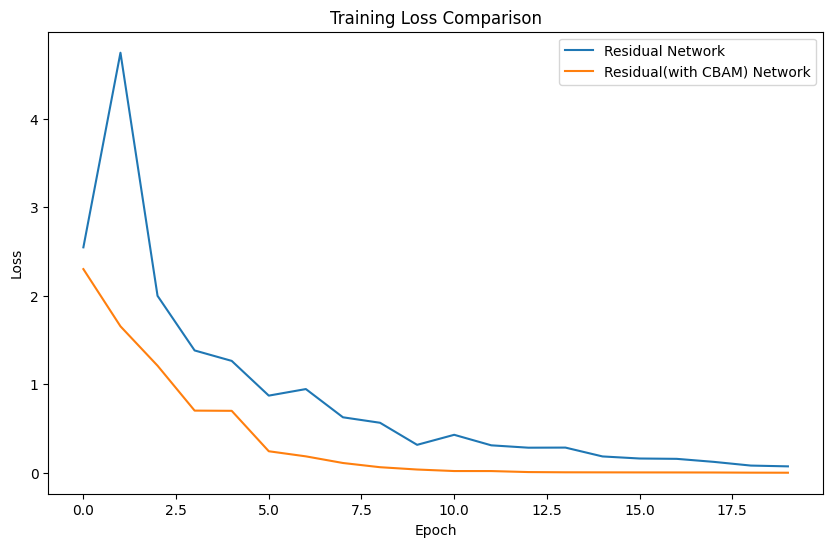

In [30]:
# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(residual_losses, label='Residual Network')
plt.plot(residual_cbam_losses, label='Residual(with CBAM) Network')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()

#โมเดล ResNet ที่มี CBAM เพิ่มเติม นั้นจะสามารถลด loss ได้มากกว่า ResNetที่ไม่มีCBAM